In [1]:
import os
import pandas as pd 
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import seaborn as sns
import itertools as it
from sklearn.decomposition import PCA

from openpyxl import Workbook, load_workbook
from openpyxl import Workbook
from openpyxl.drawing.image import Image

from scipy.spatial import ConvexHull
from scipy.interpolate import splprep, splev
from scipy.spatial import ConvexHull

sns.set_style("white")

# set project dir
from project_utils.envtools import set_project_dir
set_project_dir()

# set output dir
outdir = 'results/specimen_focused/uc_only/'
os.makedirs(outdir, exist_ok=True)

# set the random_state
random_state = 17

In [2]:
def calculate_convex_hull(points):
    hull = ConvexHull(points)
    hull_points = points[hull.vertices]
    
    hull_points = np.concatenate((hull_points, [hull_points[0]]))
    
    tck, u = splprep([hull_points[:, 0], hull_points[:, 1]], s=0, per=True)
    u_new = np.linspace(u.min(), u.max(), 100)
    x_new, y_new = splev(u_new, tck, der=0)

    return x_new, y_new 

def convex_hull_plot(ax, data, x, y, hue=None, palette=None, area_color='r-', area_alpha=0.3, edge_color='c', edge_width=1):
    """
    Params:
    ------
    hue: variable that will de extracted for coloring
    palette: dict where the key = group with the hue variable and value = color
    """
    if hue: 
        i = 0
        for grp, grp_df in data.groupby(hue):

            curr_color = palette[grp]
            points = grp_df[[x,y]].values            
            x_hull, y_hull = calculate_convex_hull(points)
            ax.plot(x_hull, y_hull, curr_color, lw=edge_width)
            ax.fill(x_hull, y_hull, curr_color, alpha=area_alpha)
            i += 1
    else:
            points = data[[x,y]].values
            x_hull, y_hull = calculate_convex_hull(points)
            ax.plot(x_hull, y_hull, area_color, lw=edge_width)
            ax.fill(x_hull, y_hull, edge_color, alpha=area_alpha)

## Load the data

In [3]:
# Load the protein levels data
protein_data = pd.read_csv("results/specimen_focused/comp_data/protein_levels.npq.tsv", sep="\t")
protein_data = protein_data.T

# extract triplet
protein_data = protein_data.loc[:,:]

# Load the clinical data
clinical_data = pd.read_csv("results/specimen_focused/comp_data/clinical_data.tsv", sep="\t")
clinical_data.loc[:, 'matched_subject_id'] = clinical_data.loc[:, 'matched_subject_id'].astype(str)

/tmp/ipykernel_93640/2572836613.py:10: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['1.0' '3.0' '7.0' '6.0' '5.0' '4.0' '8.0' '9.0' '13.0' '12.0' '11.0'
 '10.0' '14.0' '15.0' '16.0' '18.0' '19.0' '20.0' '21.0' '22.0' '23.0'
 '26.0' '25.0' '24.0' '28.0' '29.0' '9.0' '27.0' '30.0' '31.0' '13.0'
 '32.0' '33.0' '34.0' '31.0' '35.0' '6.0' '23.0' '36.0' '37.0' '38.0'
 '201.0' '16.0' '39.0' '40.0' '41.0' '42.0' '28.0' '43.0' '44.0' '45.0'
 '47.0' '8.0' '20.0' '5.0' '4.0' '48.0' '49.0' '50.0' '51.0' '52.0' '53.0'
 '54.0' '9.0' '13.0' '16.0' '25.0' '26.0' '42.0' '55.0' '31.0' '56.0'
 '57.0' '58.0' '29.0' '9.0' '28.0' '21.0' '4.0' '3.0' '59.0' '61.0' '42.0'
 '63.0' '64.0' '67.0' 'nan' 'nan' 'nan']' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  clinical_data.loc[:, 'matched_subject_id'] = clinical_data.loc[:, 'matched_subject_id'].astype(str)


In [4]:
# remove alamar samples
keep = (clinical_data['ibd_diagnosis'] == 'UC').tolist()
clinical_data = clinical_data.loc[keep,:]
protein_data = protein_data.loc[keep,:]

# # extract just CD and UC data
# focus_idxs = np.argwhere(clinical_data['ibd_diagnosis'].isin(['CD', 'UC'])).reshape(-1)
# clinical_data = clinical_data.iloc[focus_idxs]
# protein_data = protein_data.iloc[focus_idxs, :]

## Perform PCA Analysis

In [5]:
# perform pca analysis
pca = PCA(n_components=2)
principal_components = pca.fit_transform(protein_data)

# make into a dataframe
principal_components = pd.DataFrame(principal_components, columns=['pc1', 'pc2'])

# add the index
principal_components.index = protein_data.index.tolist()

# add the subject id
principal_components['matched_subject_id'] = clinical_data.matched_subject_id.astype(str).values.tolist()

# merge with the clinical data
principal_components = principal_components.merge(clinical_data, on='matched_subject_id')

In [6]:
# adding jitter for plotting purposes
np.random.seed(0)
jitter_strength = 1
principal_components.loc[:, 'pc1_with_jitter'] = principal_components.loc[:, 'pc1'] + \
    np.random.normal(0, jitter_strength, size=principal_components.shape[0])
principal_components.loc[:, 'pc2_with_jitter'] = principal_components.loc[:, 'pc2'] + \
    np.random.normal(0, jitter_strength, size=principal_components.shape[0])

In [7]:
principal_components.head()

,pc1,pc2,matched_subject_id,project_name,sample_type,sample_id,collection_date,box_id,box_location,total_volume__ml,...,ibd_diagnosis,date_collection,disease_activity,notes,ibd_indicator,disease_activity_indicator,max_crp_value,crp_severity,pc1_with_jitter,pc2_with_jitter
0,-13.170796,-10.033007,6.0,Byrd_IBD_Saliva_sup,Saliva,TRP-42324,2023-12-20 13:54:07.467,1.0,A4,1000.0,...,UC,2023-12-20,Quiescent,NaN,IBD Super Group,In-active Disease,9.0,Moderate,-11.406744,-10.420334
1,-13.170796,-10.033007,6.0,Byrd_IBD_Saliva_sup,Saliva,TRP-45520-3,2024-03-06 15:04:12.536,1.0,D7,1600.0,...,UC,2024-03-06,Mild,NaN,IBD Super Group,Active Disease,9.0,Moderate,-12.770639,-10.335310
2,7.000370,11.849115,9.0,Byrd_IBD_Saliva_sup,Saliva,TRP-42346,2024-01-03 16:18:34.612,1.0,A8,1500.0,...,UC,2024-01-03,Moderate,NaN,IBD Super Group,Active Disease,1.0,Mild,7.979108,10.800562
3,7.000370,11.849115,9.0,Byrd_IBD_Saliva_sup,Saliva,TRP-42670,2024-02-07 15:20:52.044,1.0,C7,1000.0,...,UC,2024-02-07,Quiescent,NaN,IBD Super Group,In-active Disease,1.0,Mild,9.241263,10.429097
4,7.000370,11.849115,9.0,Byrd_IBD_Saliva_sup,Saliva,TRIANGLE PEDS-009-48226-3,2024-05-08 16:34:32.545,1.0,G4,1800.0,...,UC,2024-05-08,Moderate,NaN,IBD Super Group,Active Disease,1.0,Mild,8.867928,10.142845


/tmp/ipykernel_93640/3417504934.py:38: UserWarning: Mismatched number of handles and labels: len(handles) = 2 len(labels) = 3
  ax1.legend(handles=handles[:-1], labels=leg_labels, loc=(0, 0.4), fontsize='small')


disease_activity_indicator
crp_severity


/tmp/ipykernel_93640/3417504934.py:38: UserWarning: Mismatched number of handles and labels: len(handles) = 2 len(labels) = 3
  ax1.legend(handles=handles[:-1], labels=leg_labels, loc=(0, 0.4), fontsize='small')


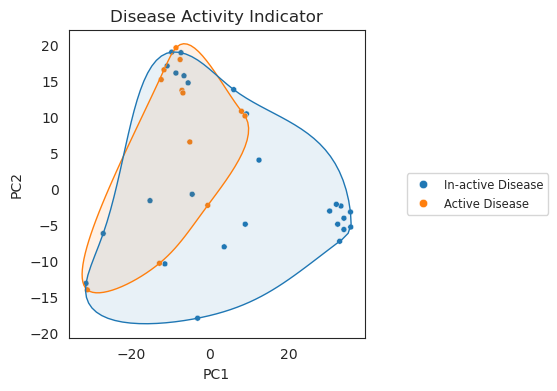

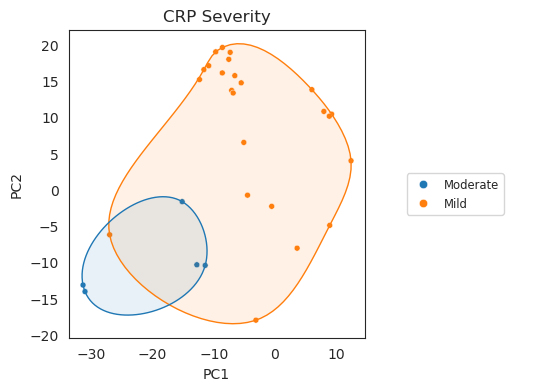

In [8]:
import matplotlib.gridspec as gridspec

labels = ['disease_activity_indicator', 'crp_severity']
titles = ['Disease Activity Indicator', 'CRP Severity']

for i in range(len(labels)):
    label = labels[i]
    title = titles[i]

    print(label)

    outcomes = principal_components[label].unique()
    palette = {k:v for k,v in zip(outcomes, sns.color_palette(n_colors=len(outcomes)).as_hex())}

    # create a grid layout with 1 row and 2 columns
    fig = plt.figure(figsize=(6, 4))
    gs = gridspec.GridSpec(1, 2, width_ratios=[7, 3], hspace=10)

    # create the scatter plot in the first subplot
    ax0 = plt.subplot(gs[0])
    sns.scatterplot(x='pc1_with_jitter', y='pc2_with_jitter', hue=label, palette=palette, data=principal_components, ax=ax0, size=1)
    convex_hull_plot(x='pc1_with_jitter', y='pc2_with_jitter', hue=label, palette=palette, data=principal_components, area_alpha=0.1, ax=ax0)

    ax0.set_title(title)
    ax0.set_xlabel('PC1')
    ax0.set_ylabel('PC2')

    # remove legend
    ax0.legend_.set_visible(False)

    # create the legend in the second subplot
    ax1 = plt.subplot(gs[1])
    ax1.axis('off')  # Turn off the axis
    handles, leg_labels = ax0.get_legend_handles_labels()
    ax1.legend(handles=handles[:-1], labels=leg_labels, loc=(0, 0.4), fontsize='small')

    # save
    outfn = os.path.join(outdir, f'Panel.pca.with_all_features.color_{label}.png')
    fig.savefig(outfn, dpi=1200)

In [9]:
principal_components.head()

,pc1,pc2,matched_subject_id,project_name,sample_type,sample_id,collection_date,box_id,box_location,total_volume__ml,...,ibd_diagnosis,date_collection,disease_activity,notes,ibd_indicator,disease_activity_indicator,max_crp_value,crp_severity,pc1_with_jitter,pc2_with_jitter
0,-13.170796,-10.033007,6.0,Byrd_IBD_Saliva_sup,Saliva,TRP-42324,2023-12-20 13:54:07.467,1.0,A4,1000.0,...,UC,2023-12-20,Quiescent,NaN,IBD Super Group,In-active Disease,9.0,Moderate,-11.406744,-10.420334
1,-13.170796,-10.033007,6.0,Byrd_IBD_Saliva_sup,Saliva,TRP-45520-3,2024-03-06 15:04:12.536,1.0,D7,1600.0,...,UC,2024-03-06,Mild,NaN,IBD Super Group,Active Disease,9.0,Moderate,-12.770639,-10.335310
2,7.000370,11.849115,9.0,Byrd_IBD_Saliva_sup,Saliva,TRP-42346,2024-01-03 16:18:34.612,1.0,A8,1500.0,...,UC,2024-01-03,Moderate,NaN,IBD Super Group,Active Disease,1.0,Mild,7.979108,10.800562
3,7.000370,11.849115,9.0,Byrd_IBD_Saliva_sup,Saliva,TRP-42670,2024-02-07 15:20:52.044,1.0,C7,1000.0,...,UC,2024-02-07,Quiescent,NaN,IBD Super Group,In-active Disease,1.0,Mild,9.241263,10.429097
4,7.000370,11.849115,9.0,Byrd_IBD_Saliva_sup,Saliva,TRIANGLE PEDS-009-48226-3,2024-05-08 16:34:32.545,1.0,G4,1800.0,...,UC,2024-05-08,Moderate,NaN,IBD Super Group,Active Disease,1.0,Mild,8.867928,10.142845
